In [1]:
import os

import numpy as np
from sklearn.decomposition import PCA

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0"
module = "encoder"
task = "rte"

In [3]:
# assertions
assert model == "bigscience-T0"
assert module == "encoder"
assert task == "rte"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

name  \
0                gpt_3_yes_no_with_targets   
1            mnli_crowdsource_with_targets   
2   based_on_previous_passage_with_targets   
3                       infer_with_targets   
4                      follow_with_targets   
5                       imply_with_targets   
6                  guaranteed_with_targets   
7                   justified_with_targets   
8                must_be_true_with_targets   
9               should_assume_with_targets   
10           gpt_3_true_false_with_targets   
11              gpt_3_cat_dog_with_targets   
12            gpt_3_yes_no_without_targets   

                                             template     category  \
0         {premise} Question: {hypothesis} Yes or No?  instructive   
1   {premise} Using only the above description and...  instructive   
2   {premise} Based on the previous passage, is it...  instructive   
3   Suppose {premise} Can we infer that "{hypothes...  instructive   
4   Given that {premise} Does it follow that {hypo...  instructive   
5   {premise} Question: Does this imply that "{hyp...  instructive   
6   Given {premise} Is it guaranteed true that "{h...  instructive   
7   {premise} Are we justified in saying that "{hy...  instructive   
8   Given that {premise} Therefore, it must be tru...  instructive   
9   Given {premise} Should we assume that "{hypoth...  instructive   
10    {premise} Question: {hypothesis} True or False?  instructive   
11       {premise} Question: {hypothesis} Cat or Dog?  instructive   
12                  {premise} Question: {hypothesis}?  instructive   

    includes_targets      targets target_ids  shuffle  
0               True    ▁Yes, ▁No       0, 1    False  
1               True    ▁Yes, ▁No       0, 1    False  
2               True    ▁Yes, ▁No       0, 1    False  
3               True    ▁Yes, ▁No       0, 1    False  
4               True    ▁Yes, ▁No       0, 1    False  
5               True    ▁Yes, ▁No       0, 1    False  
6               True    ▁Yes, ▁No       0, 1    False  
7               True    ▁Yes, ▁No       0, 1    False  
8               True    ▁Yes, ▁No       0, 1    False  
9               True    ▁Yes, ▁No       0, 1    False  
10              True  ▁True, ▁Fal       0, 1    False  
11              True   ▁Cat, ▁Dog       0, 1    False  
12             False    ▁Yes, ▁No       0, 1    False

## PCA

In [5]:
def unison_shuffled_copies(a, b):
    # from: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [8]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    # "mnli_crowdsource_with_targets",
    # "based_on_previous_passage_with_targets",
    "infer_with_targets",
    # "follow_with_targets",
    # "imply_with_targets",
    # "guaranteed_with_targets",
    # "justified_with_targets",
    # "must_be_true_with_targets",
    # "should_assume_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
    "gpt_3_yes_no_without_targets",
]

In [9]:
# for layer in range(0, 10):
for layer in range(0, 25):
# for layer in range(24, 25):
    print('layer=', layer)
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])


    # load hidden representations from hdf5 file
    representations = None
    classes = []
    n_sequences = 0

    for idx, file_name in enumerate(file_names):
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        # print(hidden_representations.shape)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

        classes += n_sequences * [idx] # assign representations to classes
    
    classes = np.asarray(classes)

    # shuffle representations and classes
    X, y = unison_shuffled_copies(representations, classes)
    print(X.shape, y.shape)

    # perform PCA on hidden representations
    print('PCA for prompts:', prompt_names)

    for n_components in range(1, 3):
        pca = PCA(n_components=n_components)
        pca.fit(X)

        # variance explained by each of the principal components
        print(f"model:{model}; module:{module}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
        print(np.sum(pca.explained_variance_ratio_))
    print('\n')


layer= 0


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5697.41it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:0; n_components: 1; variance explained: [0.95182616]
0.95182616
model:bigscience-T0; module:encoder; layer:0; n_components: 2; variance explained: [0.951826   0.00233261]
0.9541586


layer= 1


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5697.19it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:1; n_components: 1; variance explained: [0.09635692]
0.09635692
model:bigscience-T0; module:encoder; layer:1; n_components: 2; variance explained: [0.0963569  0.06580936]
0.16216627


layer= 2


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5832.24it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:2; n_components: 1; variance explained: [0.09728826]
0.09728826
model:bigscience-T0; module:encoder; layer:2; n_components: 2; variance explained: [0.0972883 0.0575892]
0.1548775


layer= 3


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5058.22it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:3; n_components: 1; variance explained: [0.09432107]
0.09432107
model:bigscience-T0; module:encoder; layer:3; n_components: 2; variance explained: [0.09432107 0.05792999]
0.15225106


layer= 4


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5631.68it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:4; n_components: 1; variance explained: [0.09910151]
0.09910151
model:bigscience-T0; module:encoder; layer:4; n_components: 2; variance explained: [0.09910148 0.06098955]
0.16009103


layer= 5


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5827.85it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:5; n_components: 1; variance explained: [0.10206242]
0.10206242
model:bigscience-T0; module:encoder; layer:5; n_components: 2; variance explained: [0.10206235 0.05997964]
0.16204199


layer= 6


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5964.12it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:6; n_components: 1; variance explained: [0.11060969]
0.11060969
model:bigscience-T0; module:encoder; layer:6; n_components: 2; variance explained: [0.11060975 0.07395395]
0.1845637


layer= 7


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5878.92it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:7; n_components: 1; variance explained: [0.11984151]
0.11984151
model:bigscience-T0; module:encoder; layer:7; n_components: 2; variance explained: [0.11984158 0.08594662]
0.2057882


layer= 8


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5906.90it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:8; n_components: 1; variance explained: [0.13897642]
0.13897642
model:bigscience-T0; module:encoder; layer:8; n_components: 2; variance explained: [0.13897637 0.09413939]
0.23311576


layer= 9


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5974.09it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:9; n_components: 1; variance explained: [0.14761558]
0.14761558
model:bigscience-T0; module:encoder; layer:9; n_components: 2; variance explained: [0.14761575 0.09731501]
0.24493076


layer= 10


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5930.69it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:10; n_components: 1; variance explained: [0.15151577]
0.15151577
model:bigscience-T0; module:encoder; layer:10; n_components: 2; variance explained: [0.1515158  0.09670202]
0.24821782


layer= 11


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5891.92it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:11; n_components: 1; variance explained: [0.16974592]
0.16974592
model:bigscience-T0; module:encoder; layer:11; n_components: 2; variance explained: [0.16974585 0.09075458]
0.26050043


layer= 12


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5642.90it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:12; n_components: 1; variance explained: [0.15622018]
0.15622018
model:bigscience-T0; module:encoder; layer:12; n_components: 2; variance explained: [0.1562202  0.10047938]
0.25669956


layer= 13


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 6019.18it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:13; n_components: 1; variance explained: [0.16250302]
0.16250302
model:bigscience-T0; module:encoder; layer:13; n_components: 2; variance explained: [0.16250303 0.12242193]
0.28492495


layer= 14


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5870.19it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:14; n_components: 1; variance explained: [0.15926081]
0.15926081
model:bigscience-T0; module:encoder; layer:14; n_components: 2; variance explained: [0.15926066 0.13020237]
0.28946304


layer= 15


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5894.73it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:15; n_components: 1; variance explained: [0.16112015]
0.16112015
model:bigscience-T0; module:encoder; layer:15; n_components: 2; variance explained: [0.16112016 0.1307372 ]
0.29185736


layer= 16


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5909.96it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:16; n_components: 1; variance explained: [0.17510565]
0.17510565
model:bigscience-T0; module:encoder; layer:16; n_components: 2; variance explained: [0.17510572 0.11958747]
0.29469317


layer= 17


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5647.92it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:17; n_components: 1; variance explained: [0.1978764]
0.1978764
model:bigscience-T0; module:encoder; layer:17; n_components: 2; variance explained: [0.1978763  0.11364234]
0.31151864


layer= 18


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5975.87it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:18; n_components: 1; variance explained: [0.21079963]
0.21079963
model:bigscience-T0; module:encoder; layer:18; n_components: 2; variance explained: [0.21079963 0.11033271]
0.32113233


layer= 19


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 6018.37it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:19; n_components: 1; variance explained: [0.20358068]
0.20358068
model:bigscience-T0; module:encoder; layer:19; n_components: 2; variance explained: [0.20358074 0.12466045]
0.3282412


layer= 20


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5930.87it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:20; n_components: 1; variance explained: [0.1670474]
0.1670474
model:bigscience-T0; module:encoder; layer:20; n_components: 2; variance explained: [0.1670474  0.14935955]
0.31640697


layer= 21


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5740.63it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:21; n_components: 1; variance explained: [0.17378332]
0.17378332
model:bigscience-T0; module:encoder; layer:21; n_components: 2; variance explained: [0.17378338 0.14173202]
0.3155154


layer= 22


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5473.35it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:22; n_components: 1; variance explained: [0.20486932]
0.20486932
model:bigscience-T0; module:encoder; layer:22; n_components: 2; variance explained: [0.20486937 0.11682476]
0.32169414


layer= 23


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5773.49it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:23; n_components: 1; variance explained: [0.2144931]
0.2144931
model:bigscience-T0; module:encoder; layer:23; n_components: 2; variance explained: [0.21449305 0.10470556]
0.3191986


layer= 24


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5595.91it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
model:bigscience-T0; module:encoder; layer:24; n_components: 1; variance explained: [0.12720805]
0.12720805
model:bigscience-T0; module:encoder; layer:24; n_components: 2; variance explained: [0.12720805 0.05247157]
0.17967962




## Visualize PCA

layer= 0


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5711.00it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:0; n_components: 2; variance explained: [0.9518263  0.00233261]
0.9541589


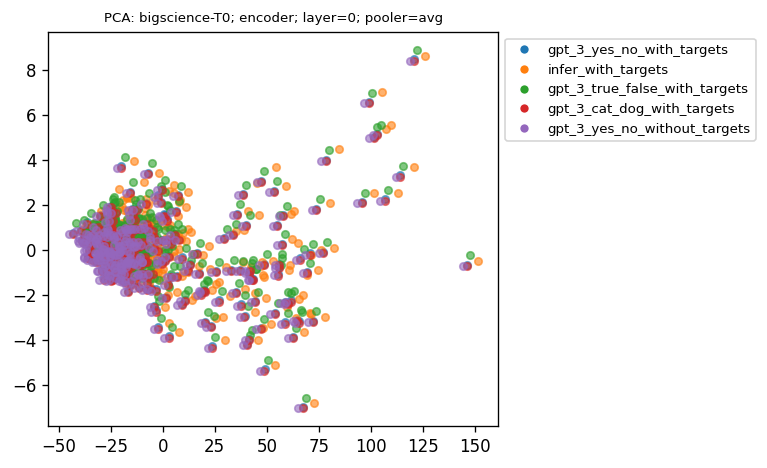



layer= 1


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5782.34it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:1; n_components: 2; variance explained: [0.09635689 0.0658093 ]
0.1621662


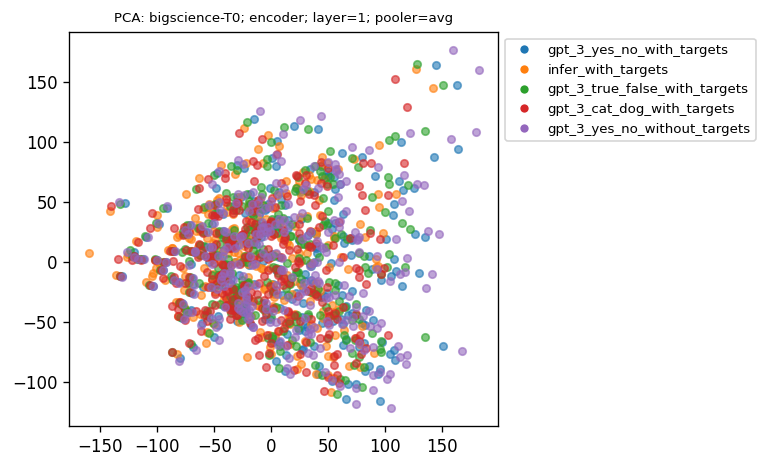



layer= 2


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5764.04it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:2; n_components: 2; variance explained: [0.09728819 0.05758926]
0.15487745


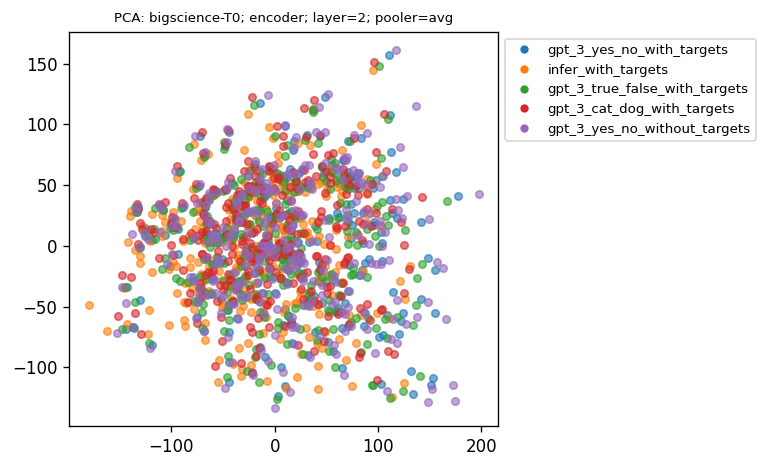



layer= 3


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5352.10it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:3; n_components: 2; variance explained: [0.09432109 0.05793   ]
0.1522511


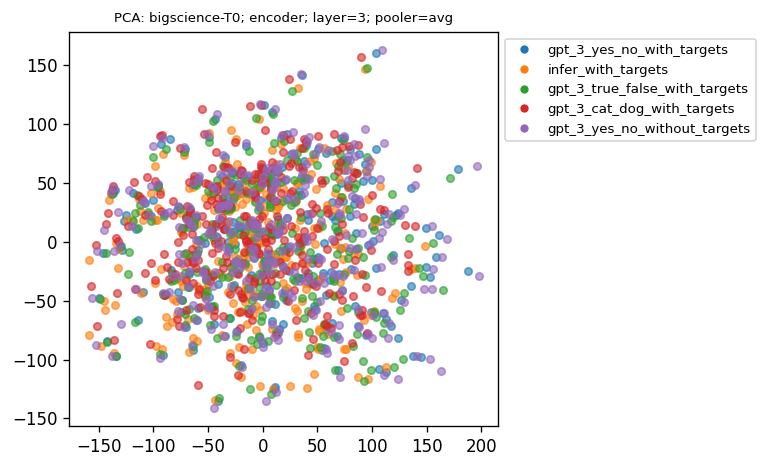



layer= 4


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5176.95it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:4; n_components: 2; variance explained: [0.0991015  0.06098946]
0.16009095


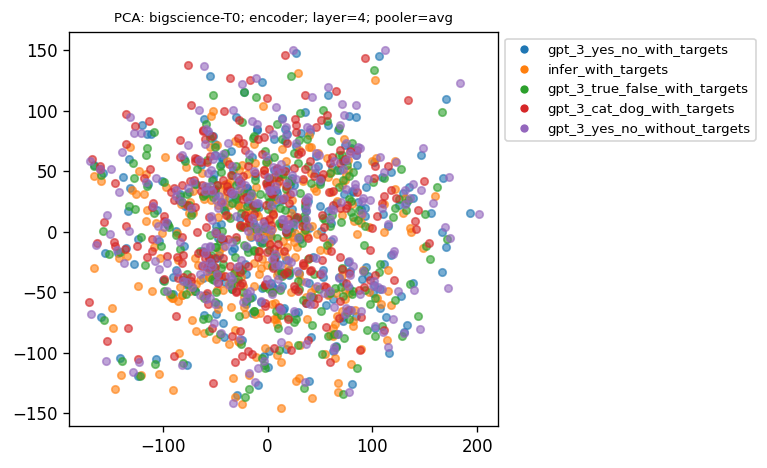



layer= 5


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5269.99it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:5; n_components: 2; variance explained: [0.10206244 0.05997963]
0.16204208


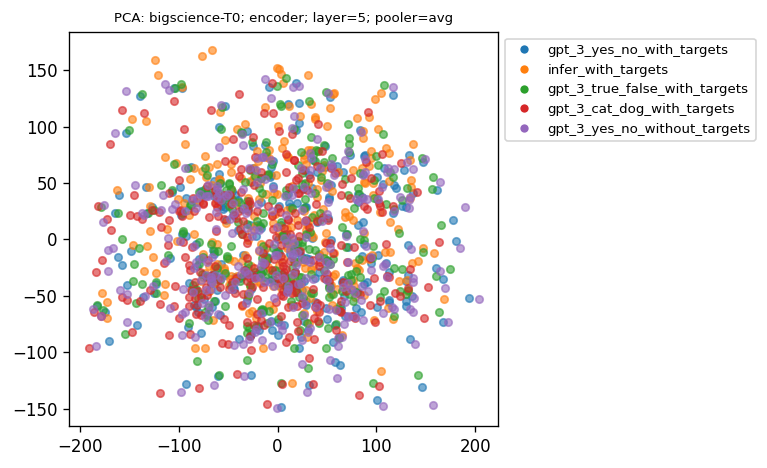



layer= 6


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5219.02it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:6; n_components: 2; variance explained: [0.11060973 0.07395406]
0.18456379


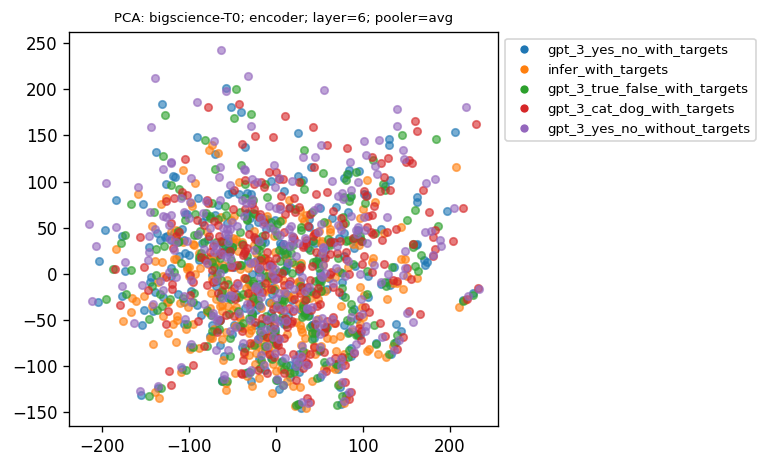



layer= 7


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5334.50it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:7; n_components: 2; variance explained: [0.11984156 0.08594666]
0.20578822


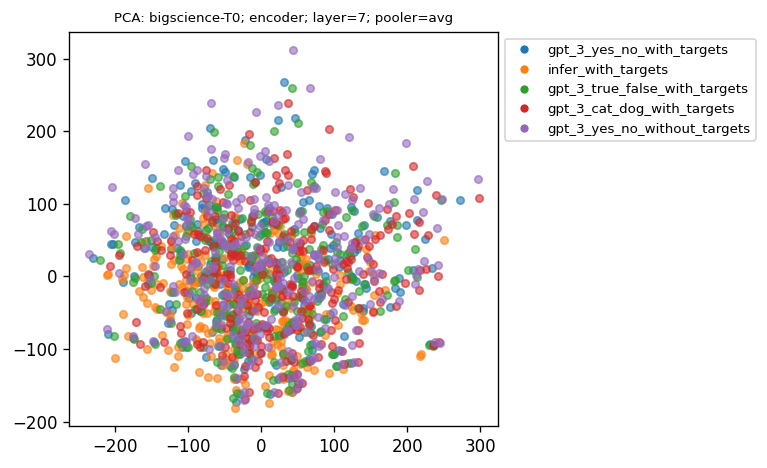



layer= 8


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5759.26it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:8; n_components: 2; variance explained: [0.13897634 0.09413937]
0.2331157


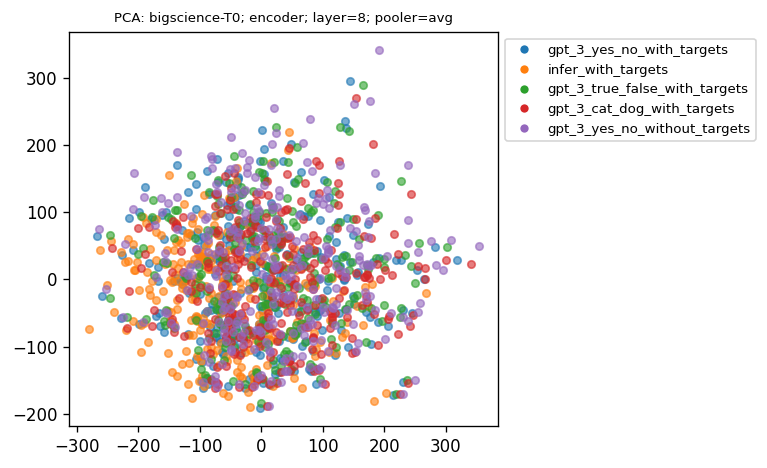



layer= 9


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5471.75it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:9; n_components: 2; variance explained: [0.14761563 0.09731487]
0.2449305


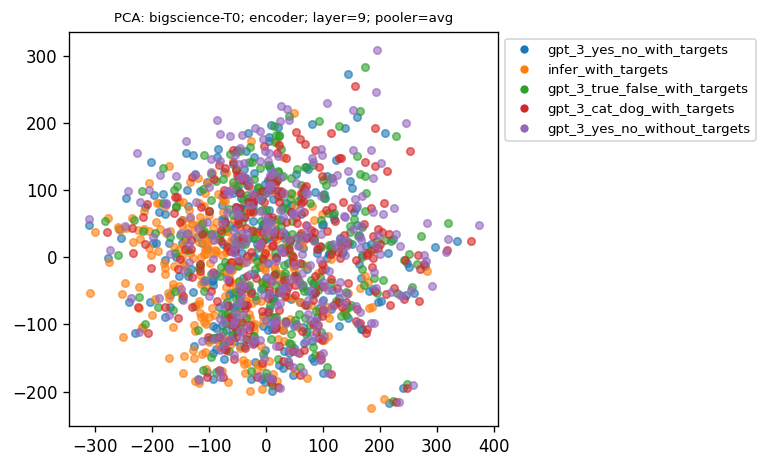



layer= 10


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5511.15it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:10; n_components: 2; variance explained: [0.15151583 0.09670202]
0.24821785


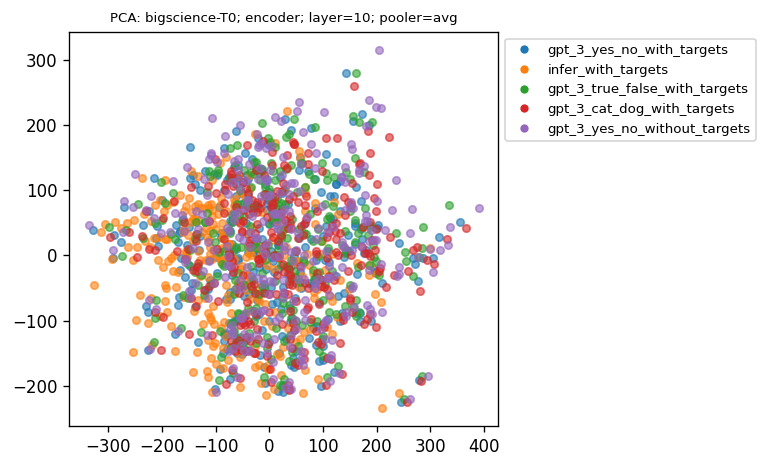



layer= 11


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5447.20it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:11; n_components: 2; variance explained: [0.16974598 0.09075458]
0.26050055


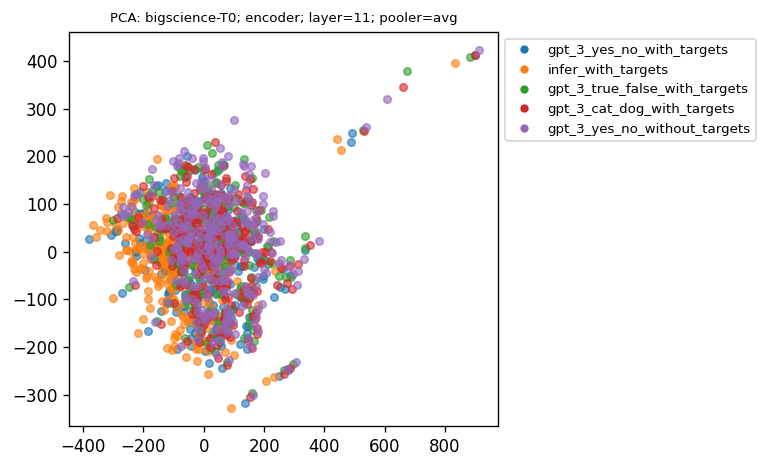



layer= 12


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5726.05it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:12; n_components: 2; variance explained: [0.15622017 0.10047935]
0.2566995


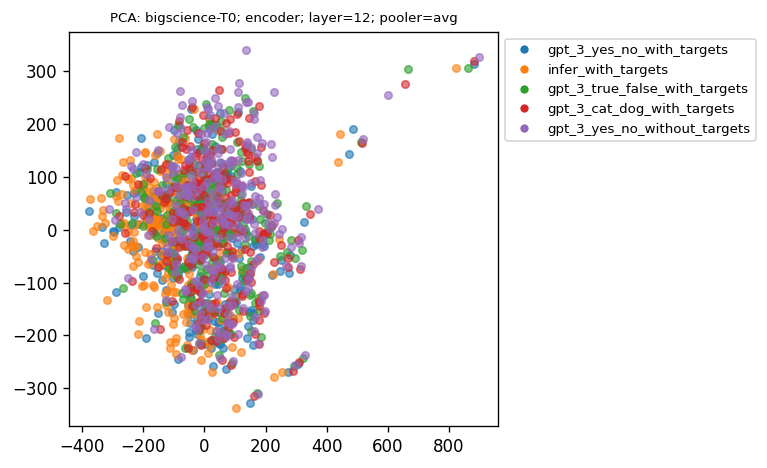



layer= 13


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5662.81it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:13; n_components: 2; variance explained: [0.16250291 0.12242216]
0.28492507


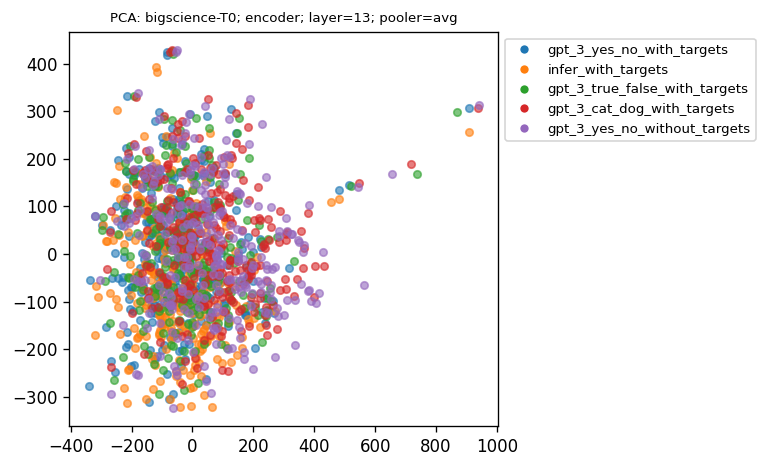



layer= 14


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4971.40it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:14; n_components: 2; variance explained: [0.15926073 0.13020241]
0.28946316


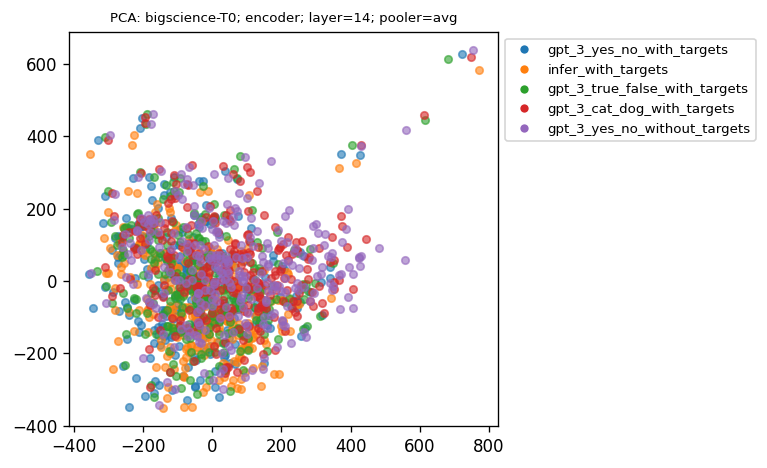



layer= 15


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5862.90it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:15; n_components: 2; variance explained: [0.16112009 0.13073726]
0.29185736


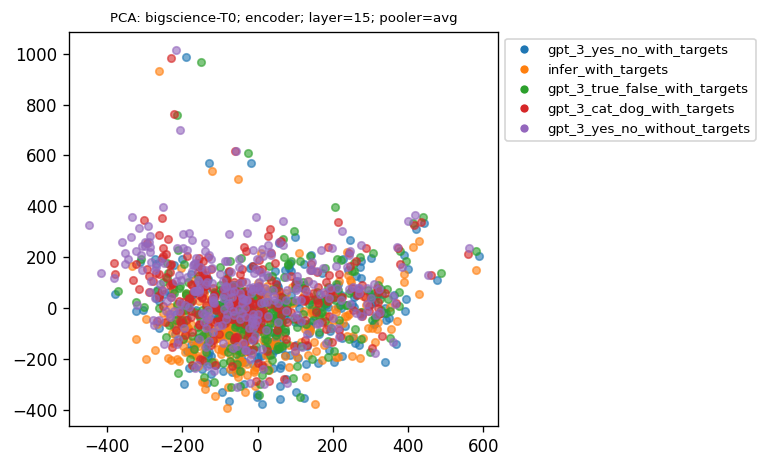



layer= 16


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5190.07it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:16; n_components: 2; variance explained: [0.17510566 0.11958758]
0.29469323


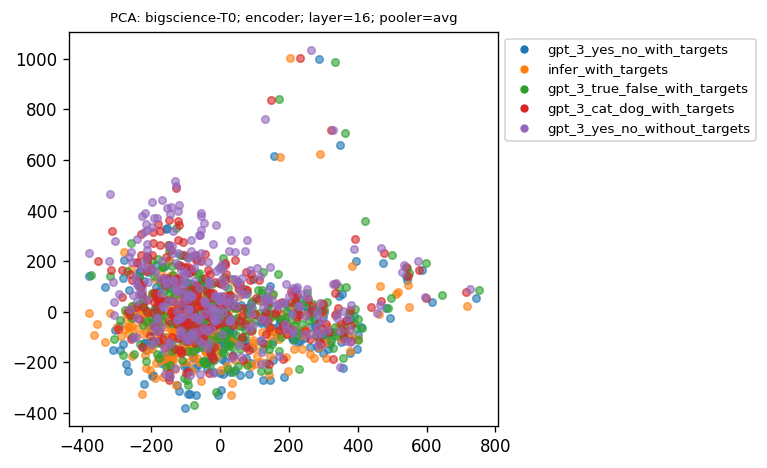



layer= 17


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5084.58it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:17; n_components: 2; variance explained: [0.19787644 0.1136422 ]
0.31151864


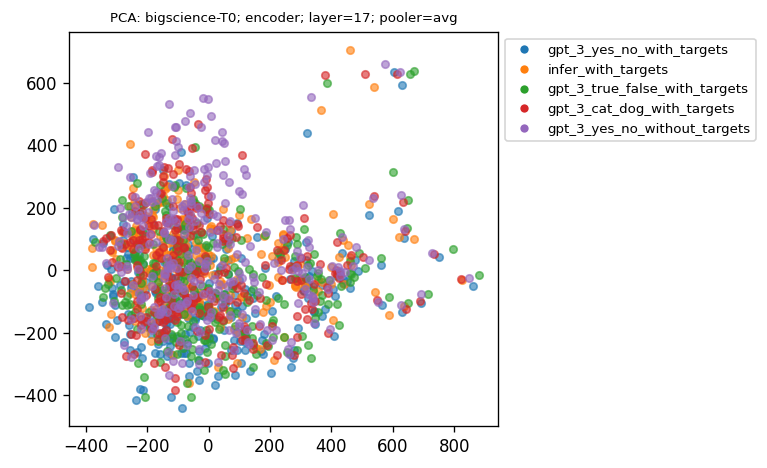



layer= 18


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5948.91it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:18; n_components: 2; variance explained: [0.21079957 0.11033262]
0.32113218


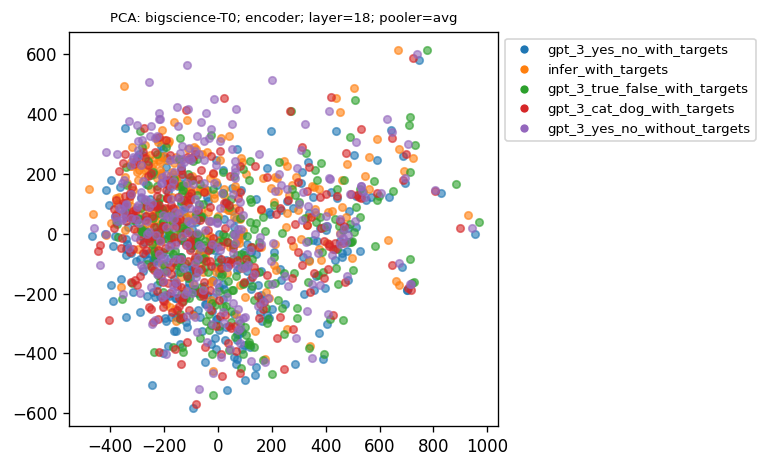



layer= 19


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4998.01it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:19; n_components: 2; variance explained: [0.20358081 0.12466078]
0.3282416


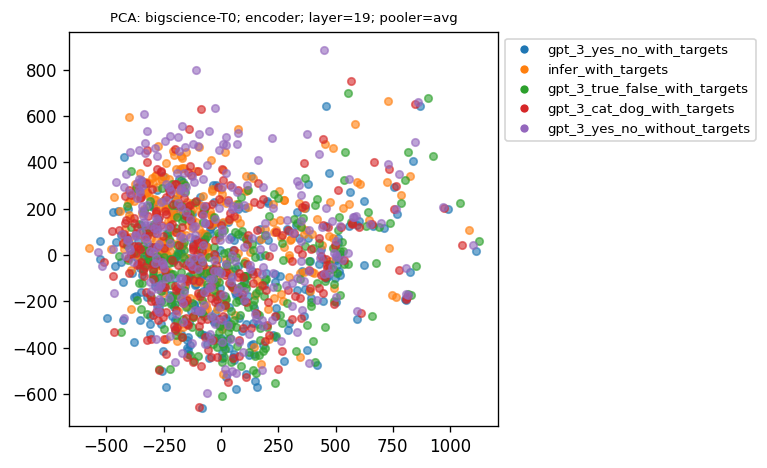



layer= 20


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5747.13it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:20; n_components: 2; variance explained: [0.16704734 0.14935954]
0.31640688


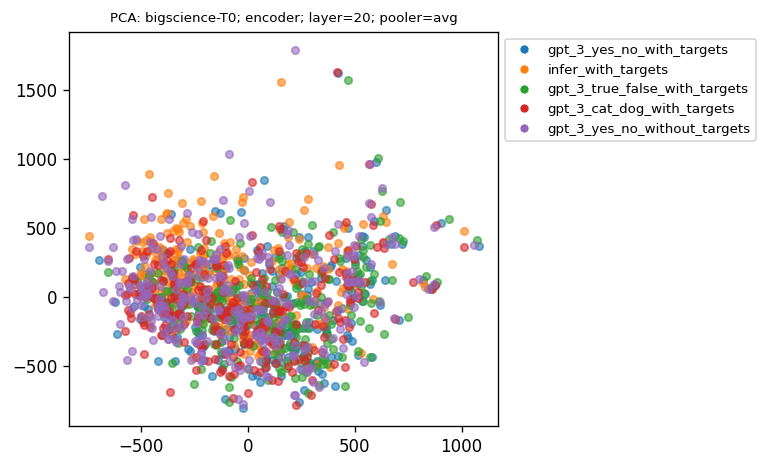



layer= 21


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5877.20it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:21; n_components: 2; variance explained: [0.17378336 0.14173204]
0.3155154


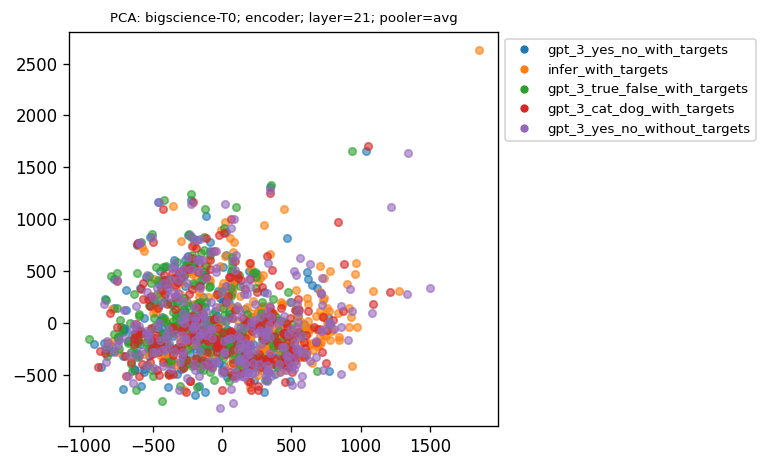



layer= 22


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5860.92it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:22; n_components: 2; variance explained: [0.20486926 0.11682473]
0.321694


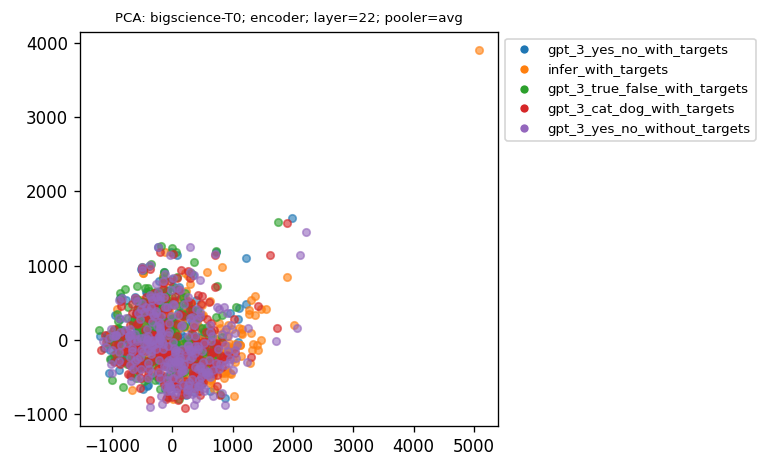



layer= 23


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5525.70it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:23; n_components: 2; variance explained: [0.21449311 0.10470556]
0.31919867


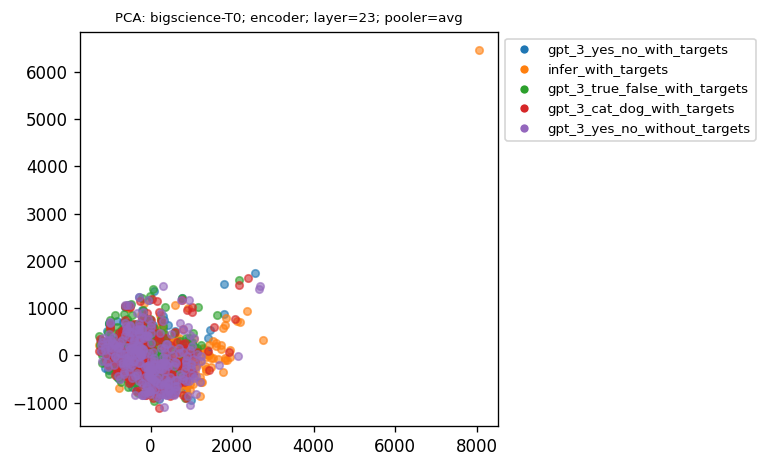



layer= 24


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5989.27it/s]


(1385, 4096) (1385,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'infer_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets']
(1385, 2)
model:bigscience-T0; module:encoder; layer:24; n_components: 2; variance explained: [0.12720808 0.05247153]
0.17967962


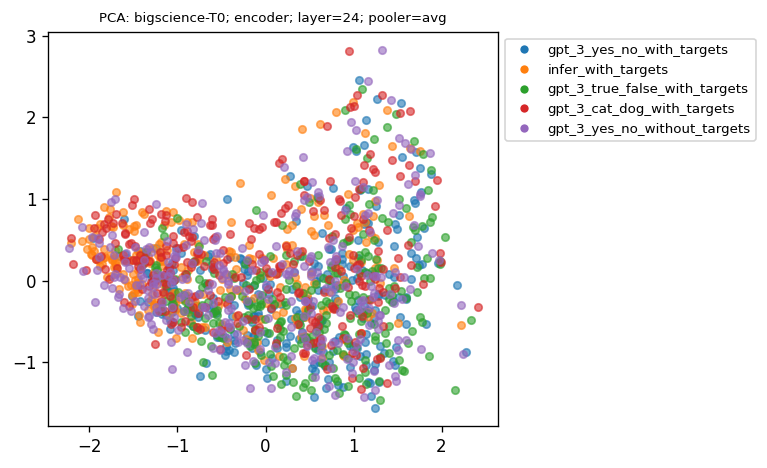

In [11]:
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('tab20')
colors = cmap.colors

# for layer in range(0, 1):
for layer in range(0, 25):
# for layer in range(24, 25):
    print('layer=', layer)
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])


    # load hidden representations from hdf5 file
    representations = None
    classes = []
    n_sequences = 0

    for idx, file_name in enumerate(file_names):
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        # print(hidden_representations.shape)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

        classes += n_sequences * [idx] # assign representations to classes
    
    classes = np.asarray(classes)

    X, y = representations, classes
    # shuffle representations and classes
    # X, y = unison_shuffled_copies(representations, classes)
    print(X.shape, y.shape)

    # perform PCA on hidden representations
    print('PCA for prompts:', prompt_names)

    for n_components in range(2, 3):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit(X).transform(X)
        print(X_pca.shape)

        # variance explained by each of the principal components
        print(f"model:{model}; module:{module}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
        print(np.sum(pca.explained_variance_ratio_))

        # plot PCA embeddings
        fig, axes = plt.subplots(1, 1, figsize=(6.5,4), dpi=120)
        legend_elements= []

        for idx, file_name in enumerate(file_names):
            x, y = X_pca[n_sequences*idx:n_sequences*(idx + 1), 0], X_pca[n_sequences*idx:n_sequences*(idx + 1), 1]
            axes.scatter(x, y, alpha=0.6, s=[20.0], color=colors[idx])

            # create legend element manually
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=prompt_names[idx], markerfacecolor=colors[idx], markersize=6))
        
        axes.set_title(f"PCA: {model}; {module}; layer={layer}; pooler=avg", fontsize=8)
        axes.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

        plt.tight_layout()

        plt.show()
        plt.close();
        
    print('\n')
